# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
agent_1 = states[0]
print('The state for the first agent looks like:', agent_1.shape)

rewards = (env_info.rewards) # get the rewards
dones = (env_info.local_done) # and whether the env is done

TennisBrain
Number of agents: 2
Size of each action: 2
(2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: (24,)


In [4]:
import numpy as np
import gym
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from collections import OrderedDict

In [5]:
## Initialise parameters ##
All_Noise_Type = ['param','OUNoise','BetaNoise', 'GaussNoise', 'WeightedNoise' ]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
p = OrderedDict()

p.update(state_size=state_size) 
p.update(action_size=action_size)
p.update(hidden_in_size=400) 
p.update(hidden_out_size=300)
p.update(lr_actor=0.001) 
p.update(lr_critic=0.001)
p.update(l2_decay=0.000)
p.update(noise_type=All_Noise_Type[1])
p.update(OU_mu=0.0)
p.update(OU_theta=0.15)
p.update(OU_sigma=0.2)
p.update(device=device)
p.update(Total_Agent=num_agents)
p.update(desired_distance=0.5)
p.update(Param_scale_Noise=0.05)
p.update(Param_scale_Noise_decay=0.99)
p.update(Batch_Normalize=True)
p.update(Q_Distribution=False)

# Not implemented yet. Don't alter the if-else condition
if(p['Q_Distribution'] == False):
    p.update(QD_log_active=False)
    p.update(num_atoms=1, vmin=-0.1, vmax=1)
else:
    p.update(QD_log_active=True)
    p.update(num_atoms=51, vmin=-0.1, vmax=1)


## Replay_Buffer_parameters ##
p.update(buffer_size=int(1e6), n_steps=5, n_steps_active=False)

## Agent_parameters ##
p.update(discount_rate=0.99, tau=0.001)

## Model_parameters ##
p.update(batchsize=128)

## Noise_parameters ##
p.update(noise_reduction=0.99 , noise_scale_end=0.001)

In [6]:
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
#from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor, hard_update, soft_update
from collections import deque

## Episode_parameters ##
p.update(number_of_episodes=10000, episode_length=1000, print_every = 100, warmup = 1000,
                                 UPDATE_EVERY=2, Num_Updates=10)

# set the random seed - this allows for reproducibility
start_seed = 5
random.seed(start_seed)
np.random.seed(start_seed)
torch.manual_seed(start_seed)

# amplitude of noise
# this slowly decreases to 0
noise_reduction = p['noise_reduction'] # each episode we decay the noise by this
noise_scale = np.ones(num_agents) # we start the noise at 1
noise_scale_end = p['noise_scale_end'] # the noise will never drop below this


# some performance metrics to keep track of for graphing afterwards
scores = []
avg_scores = []
scores_deque = deque(maxlen=100)

# keep 50000 timesteps worth of replay, with n-step-5 bootstraping, and 0.99 discount rate
buffer = ReplayBuffer(p['buffer_size'], p['n_steps'], p['discount_rate'], p['n_steps_active'])

# initialize actor and critic networks and ddpg agents, passing all parameters to it
maddpg = MADDPG(p)
maddpg.load_models()


for episode in range(0,p['number_of_episodes']):
    env_info = env.reset(train_mode=True)[brain_name] # initialise the environment    
    
    for agent_num in range(num_agents): # for both agents
        noise_scale[agent_num] = max(noise_scale[agent_num]*noise_reduction,noise_scale_end) # then reduce noise

    
    buffer.reset() # reseting the buffer is neccessary to ensure the n-step bootstraps reset after each episode
    reward_this_episode = np.zeros(num_agents) # keeping track of episode reward
           
    states      = env_info.vector_observations     # It is a 2 X 24 numpy array
    step_num = 0    
    
    for episode_t in range(p['episode_length']):
        
        # explore only for a certain number of episodes
        # action input needs to be transposed
        
        actions_array = maddpg.act(states, noise_scale=noise_scale)       
        env_info      = env.step(actions_array)[brain_name]   # input the actions into the env
        next_states   = env_info.vector_observations # get the next states
        rewards       = env_info.rewards     # get the rewards
        dones         = env_info.local_done # and whether the env is done

        # add data to buffer
        buffer.add(states, actions_array, rewards, next_states, dones)
        
        states = next_states # after each timestep update the obs to the new obs before restarting the loop
        
        # for calculating rewards for this particular episode - addition of all time steps
        reward_this_episode += rewards
        
        
        step_num += 1
        
        if (len(buffer) > p['warmup']): 
            if step_num%p['UPDATE_EVERY'] == 0:
                for _ in range(p['Num_Updates']): # learn multiple times at every step                    
                    for agent_num in range(p['Total_Agent']): # for both agents
                        samples = buffer.sample(p['batchsize']) # sample the buffer
                        maddpg.update(samples, agent_num) # update the agent
                        maddpg.update_targets(agent_num) # soft update the target network towards the actual networks
                        
        if np.any(dones):                                  # exit loop if episode finished
            break
            
            
    # update the episode scores 
    eps_score = np.max(reward_this_episode)
    scores_deque.append(eps_score)
    scores.append(eps_score) 
        

    # add average score to tensorboard
    print('\rEpisode {}\t  Score: {:.2f}'.format(episode, eps_score), end="")
   
    if episode > 0:
        if episode % p['print_every'] == 0:
            avg_score = np.mean(scores_deque)
            avg_scores.append(avg_score)
            print('\rEpisode {}\tAverage Score in 100 episodes: {:.2f}'.format(episode, avg_score))
            maddpg.save_models()
    
    if episode >= 100:
        avg_score = np.mean(scores_deque)
        if avg_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, avg_score))
            maddpg.save_models()
            print('Models saved successfully')
            break
                
   



Models loaded succesfully
Episode 0	Average Score in 100 episodes: 0.00
Episode 100	Average Score in 100 episodes: 0.14
Episode 200	Average Score in 100 episodes: 0.30
Episode 252	  Score: 2.60
Environment solved in 152 episodes!	Average Score: 0.51
Models saved successfully


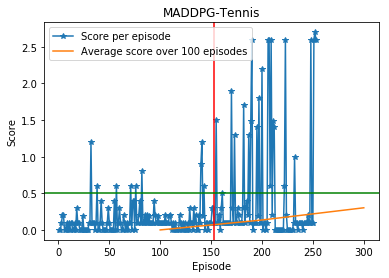

In [8]:
episodes = list(range(1, len(scores)+1))
plt.plot(episodes, scores,marker='*', label="Score per episode")
plt.plot(np.array(list(range(1,len(avg_scores)+1)))*100,avg_scores, label="Average score over 100 episodes")
plt.title("MADDPG-Tennis")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.axvline(episodes[-1]-100,color='r')
plt.axhline(0.5,color='g')
plt.legend()
plt.savefig('MADDPG_Tennis_score.png', bbox_inches='tight')


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 